In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [187]:
df = pd.read_csv('merged_data.csv')
df['deposit_by_area'] = df['deposit'] / df['area_m2']
df

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,...,total_large_park_area_10km,nearest_subway_distance_km,school_count_within_1km,closest_elementary_distance,closest_middle_distance,closest_high_distance,deposit_mean,interest_rate,interest_rate_diff,deposit_by_area
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,...,3082215.1,0.716953,4,0.156120,0.465125,0.990855,31188.259433,1.92,-0.07,200.004471
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,...,3082215.1,0.716953,4,0.156120,0.465125,0.990855,32309.834287,1.63,0.08,270.594284
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,...,3082215.1,0.716953,4,0.156120,0.465125,0.990855,32309.834287,1.63,0.08,270.594284
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,...,1877924.1,3.897280,4,0.214560,0.688047,0.644366,31786.283137,1.94,0.02,84.260195
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,...,2199482.1,2.039685,0,1.708489,2.197946,2.264822,30459.486563,2.04,NaN,30.095302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867778,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,0.0,...,10819839.1,1.483045,7,0.313129,0.482436,0.224754,46357.076007,3.97,0.15,0.000000
1867779,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,0.0,...,10819839.1,1.483045,7,0.313129,0.482436,0.224754,46711.029696,4.00,0.03,0.000000
1867780,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,0.0,...,10819839.1,1.483045,7,0.313129,0.482436,0.224754,46711.029696,4.00,0.03,0.000000
1867781,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,0.0,...,10819839.1,1.483045,7,0.313129,0.482436,0.224754,46711.029696,4.00,0.03,0.000000


# 1. 위도 경도를 기준으로 DBSCAN

In [188]:
apartment = df[df['contract_year_month'] < 202401][['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
apartment

,latitude,longitude
0,37.054314,127.045216
1,36.964647,127.055847
2,36.972390,127.084514
3,36.965423,127.048779
4,36.957089,127.047449
...,...,...
18486,37.612604,126.657868
18487,37.584117,126.716550
18488,37.582593,126.716193
18489,37.581261,126.706269


In [189]:
scaler = StandardScaler()
apartment_scaled = scaler.fit_transform(apartment)


In [190]:
apartment.shape

(18491, 2)

In [191]:
# DataFrame으로 변환
apartment_scaled_df = pd.DataFrame(apartment_scaled, columns=['latitude', 'longitude'])


## (1) eps 값 구하기

Change point at index 18485, distance: 0.4152021669639914
Change point at index 18488, distance: 0.5381801681808399


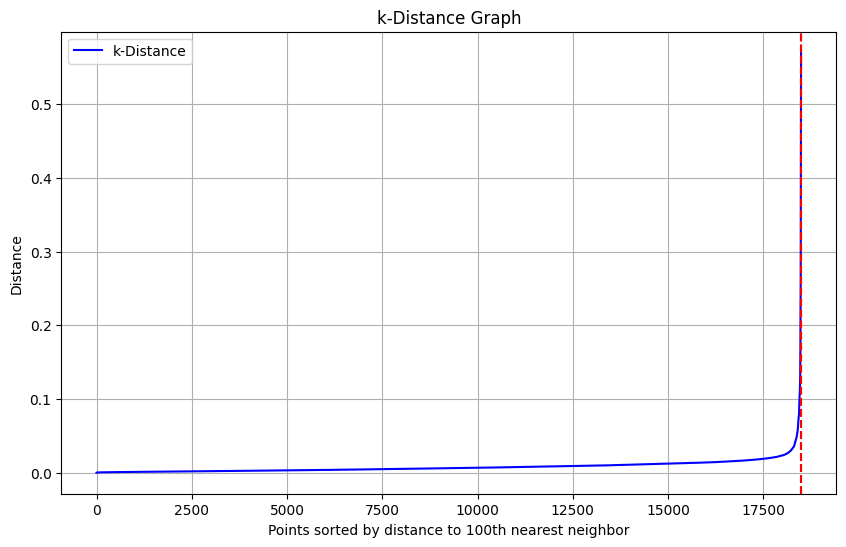

In [192]:
# k 설정 (min_samples와 같거나 그 이상)
k = 100  # 또는 다른 적절한 값

# NearestNeighbors 모델을 통해 거리 계산
nbrs = NearestNeighbors(n_neighbors=k).fit(apartment_scaled)
distances, indices = nbrs.kneighbors(apartment_scaled)

# k번째 이웃 거리 추출 및 정렬
k_distances = np.sort(distances[:, 1])  # k번째 이웃의 거리
plt.figure(figsize=(10, 6))

# k-거리 그래프
plt.plot(k_distances, label='k-Distance', color='blue')

# 기울기가 급격히 변하는 지점 찾기
# 1차 미분 계산
deltas = np.diff(k_distances)

# 기울기 급변 지점 찾기: 변화량의 절댓값이 임계값을 넘는 지점
threshold = 0.05  # 변화량의 기준값
change_points = np.where(np.abs(deltas) > threshold)[0]

# 그래프에 빨간 줄 추가
for point in change_points:
    plt.axvline(x=point, color='red', linestyle='--')
    print(f"Change point at index {point}, distance: {k_distances[point + 1]}")

plt.title('k-Distance Graph')
plt.xlabel('Points sorted by distance to {}th nearest neighbor'.format(k))
plt.ylabel('Distance')
plt.grid()
plt.legend()
plt.show()

- 작은 값이 좋음 -> eps = 0.4152

## (2) min samples -> 실루엣 점수를 확인해서 정하기

In [193]:
# DBSCAN 모델 적용
dbscan = DBSCAN(eps=0.4152, min_samples=100)  # 예시로 eps는 이전에 찾은 값
labels = dbscan.fit_predict(apartment_scaled_df)

# 실루엣 점수 계산
if len(set(labels)) > 1:  # 군집이 1개 이상일 경우에만 계산
    silhouette_avg = silhouette_score(apartment_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Not enough clusters to compute Silhouette Score.")


Silhouette Score: 0.4624025221131352


## (3) 적용

/tmp/ipykernel_866039/253729421.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(apartment_scaled_df.loc[labels == label, 'longitude'],


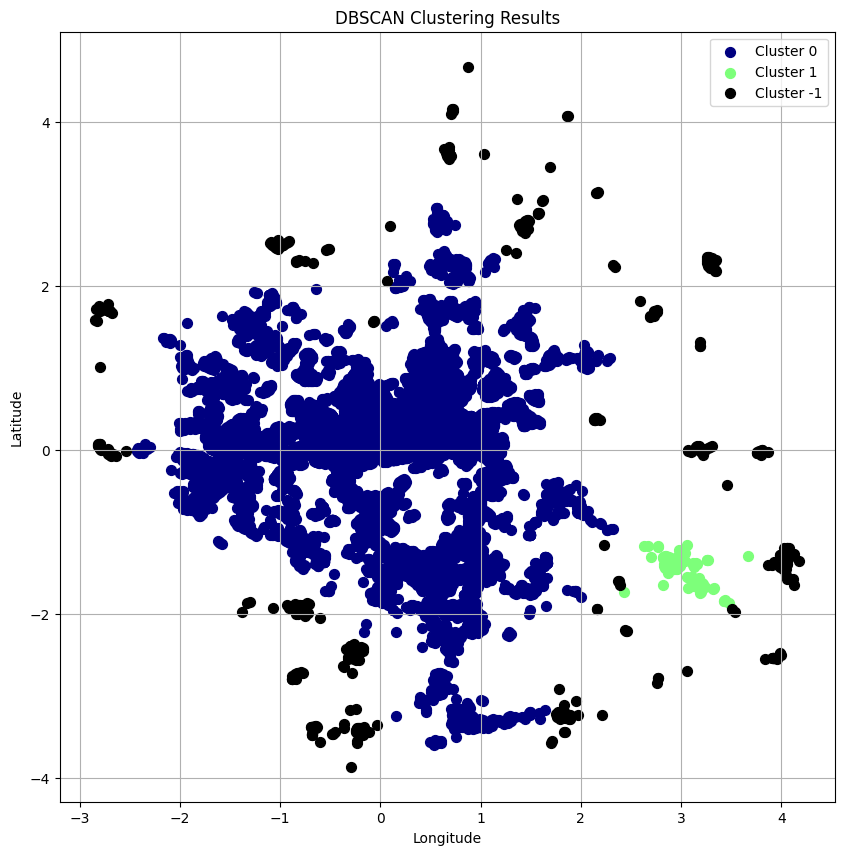

In [194]:
# DBSCAN 적용
dbscan = DBSCAN(eps=0.4152, min_samples=100)
labels = dbscan.fit_predict(apartment_scaled_df)

# 시각화
plt.figure(figsize=(10, 10))
unique_labels = set(labels)

for label in unique_labels:
    if label == -1:
        # 노이즈는 검은색
        color = 'k'
    else:
        color = plt.cm.jet(label / (max(unique_labels) + 1)) 

    plt.scatter(apartment_scaled_df.loc[labels == label, 'longitude'], 
                apartment_scaled_df.loc[labels == label, 'latitude'], 
                s=50, c=color, label=f'Cluster {label}')

plt.title('DBSCAN Clustering Results')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()

In [195]:
apartment_scaled_df['cluster1'] = labels
apartment_scaled_df.head(3)

,latitude,longitude,cluster1
0,-2.945573,0.519665,0
1,-3.551297,0.582879,0
2,-3.498991,0.753341,0


## (4) 재적용

/tmp/ipykernel_866039/3056366653.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_0_data.loc[cluster_0_labels == label, 'longitude'],


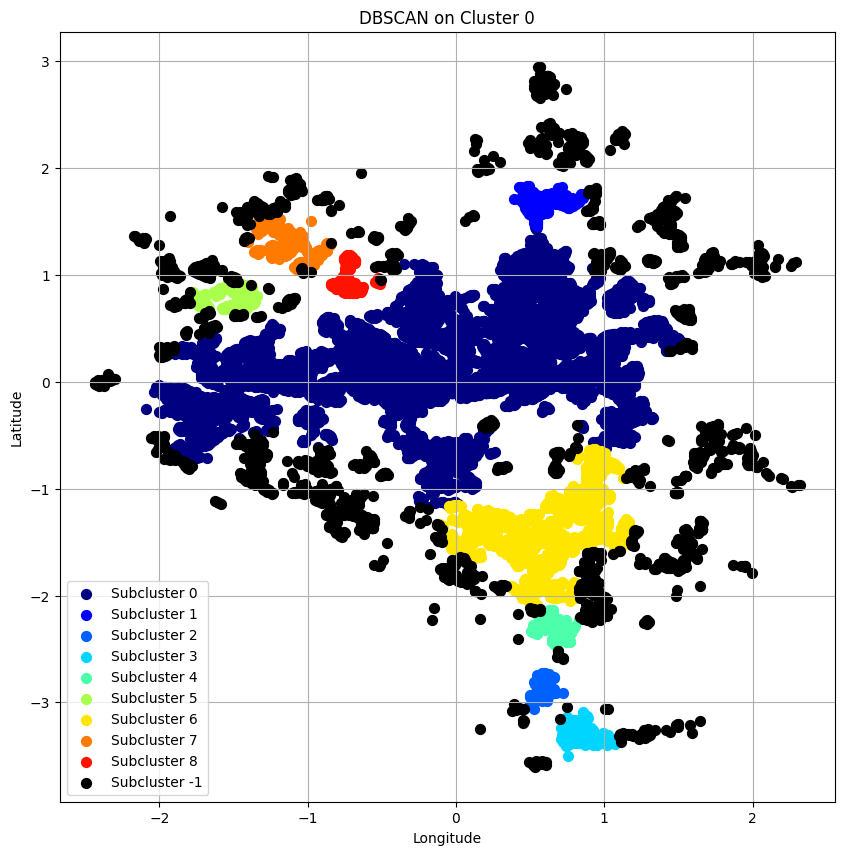

In [197]:
cluster_0_data = apartment_scaled_df[labels == 0]

cluster_0_scaled = scaler.transform(cluster_0_data[['latitude', 'longitude']])

# DBSCAN 재적용
eps = 1.0  # 적절한 eps 값을 설정
min_samples = 100  # 클러스터의 최소 샘플 수

dbscan_cluster_0 = DBSCAN(eps=eps, min_samples=min_samples)
cluster_0_labels = dbscan_cluster_0.fit_predict(cluster_0_scaled)

# 군집화 결과 시각화
plt.figure(figsize=(10, 10))
unique_labels_cluster_0 = set(cluster_0_labels)

for label in unique_labels_cluster_0:
    if label == -1:
        # 노이즈 포인트는 검은색으로 표시
        color = 'k'
    else:
        color = plt.cm.jet(label / (max(unique_labels_cluster_0) + 1)) 

    plt.scatter(cluster_0_data.loc[cluster_0_labels == label, 'longitude'], 
                cluster_0_data.loc[cluster_0_labels == label, 'latitude'], 
                s=50, c=color, label=f'Subcluster {label}')

plt.title('DBSCAN on Cluster 0')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()


In [198]:
apartment_scaled_df.loc[labels == 0, 'cluster2'] = cluster_0_labels
apartment_scaled_df.head(3)

,latitude,longitude,cluster1,cluster2
0,-2.945573,0.519665,0,2.0
1,-3.551297,0.582879,0,-1.0
2,-3.498991,0.753341,0,3.0


In [199]:
apartment_scaled_df['cluster2'].value_counts()

cluster2
 0.0    13044
-1.0     2142
 6.0     1425
 1.0      263
 7.0      253
 8.0      185
 5.0      164
 3.0      147
 2.0      122
 4.0      117
Name: count, dtype: int64

/tmp/ipykernel_866039/2384662389.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_2_data.loc[cluster_2_labels == label, 'longitude'],


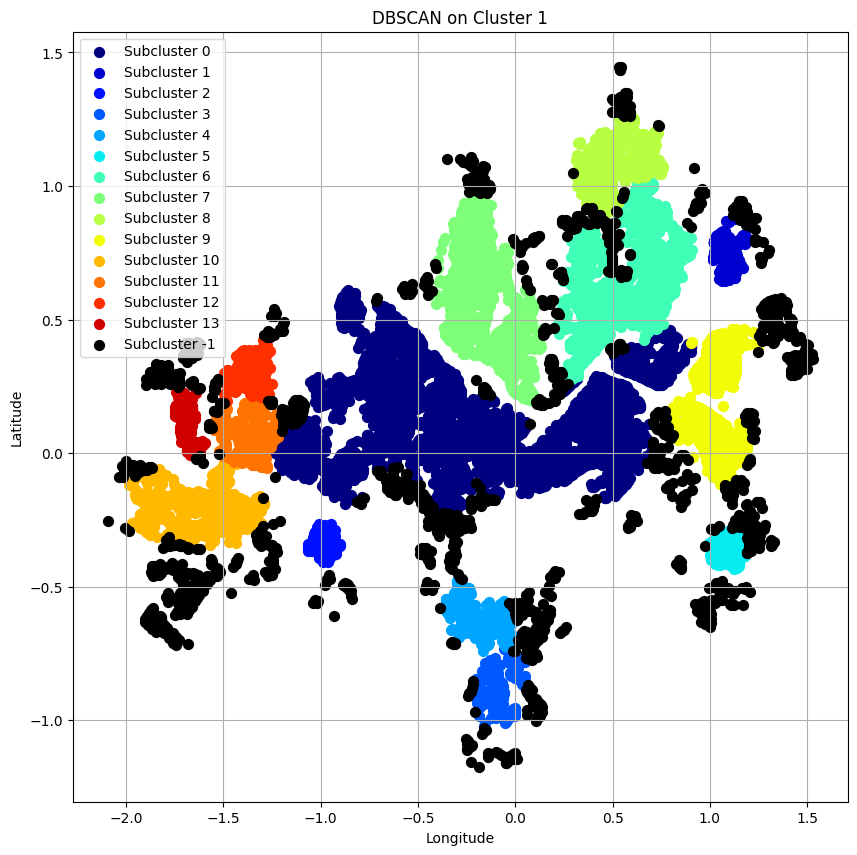

In [220]:
cluster_2_data = apartment_scaled_df[apartment_scaled_df['cluster2'] == 0]
cluster_2_scaled = scaler.transform(cluster_2_data[['latitude', 'longitude']])

# 클러스터 2에 대해 DBSCAN 재적용
eps = 0.5
min_samples = 80

dbscan_cluster_2 = DBSCAN(eps=eps, min_samples=min_samples)
cluster_2_labels = dbscan_cluster_2.fit_predict(cluster_2_scaled)

# 시각화
plt.figure(figsize=(10, 10))
unique_labels_cluster_2 = set(cluster_2_labels)

for label in unique_labels_cluster_2:
    if label == -1:
        # 노이즈는 검은색
        color = 'k'
    else:
        color = plt.cm.jet(label / (max(unique_labels_cluster_2) + 1)) 

    plt.scatter(cluster_2_data.loc[cluster_2_labels == label, 'longitude'], 
                cluster_2_data.loc[cluster_2_labels == label, 'latitude'], 
                s=50, c=color, label=f'Subcluster {label}')

plt.title('DBSCAN on Cluster 1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()


In [205]:
apartment_scaled_df.loc[apartment_scaled_df['cluster2'] == 0, 'cluster3'] = cluster_2_labels
apartment_scaled_df.head(3)


,latitude,longitude,cluster1,cluster2,cluster3
0,-2.945573,0.519665,0,2.0,NaN
1,-3.551297,0.582879,0,-1.0,NaN
2,-3.498991,0.753341,0,3.0,NaN


In [206]:
# NaN 값을 제외한 cluster1, cluster2, cluster3의 고유 값 출력
print(set(apartment_scaled_df['cluster1'].dropna()))
print(set(apartment_scaled_df['cluster2'].dropna()))
print(set(apartment_scaled_df['cluster3'].dropna()))


{0, 1, -1}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, -1.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, -1.0}


In [207]:
# 세 개의 클러스터 값을 문자열로 결합하여 유니크한 조합을 만듦
apartment_scaled_df['cluster_combination'] = (
    apartment_scaled_df['cluster1'].astype(str) + "_" + 
    apartment_scaled_df['cluster2'].astype(str) + "_" + 
    apartment_scaled_df['cluster3'].astype(str)
)

# 결합된 조합을 고유한 값으로 매핑
apartment_scaled_df['cluster_final'] = apartment_scaled_df['cluster_combination'].factorize()[0]

# 결과 확인
print(apartment_scaled_df[['cluster1', 'cluster2', 'cluster3', 'cluster_final']].head())

# 고유한 라벨 개수 확인
print("고유 라벨 수:", apartment_scaled_df['cluster_final'].nunique())


   cluster1  cluster2  cluster3  cluster_final
0         0       2.0       NaN              0
1         0      -1.0       NaN              1
2         0       3.0       NaN              2
3         0      -1.0       NaN              1
4         0      -1.0       NaN              1
고유 라벨 수: 26


In [208]:
apartment_final = pd.concat([apartment[['latitude', 'longitude']], apartment_scaled_df['cluster_final']],axis=1)
apartment_final.head(3)

,latitude,longitude,cluster_final
0,37.054314,127.045216,0
1,36.964647,127.055847,1
2,36.972390,127.084514,2


In [217]:
apartment_final['cluster_final'].value_counts()

cluster_final
7     4965
1     2142
8     1558
6     1425
19    1308
21    1255
13     932
23     790
3      480
22     478
20     401
16     303
9      263
14     253
12     253
10     219
24     208
18     185
15     164
5      149
2      147
25     146
0      122
4      117
11     117
17     111
Name: count, dtype: int64

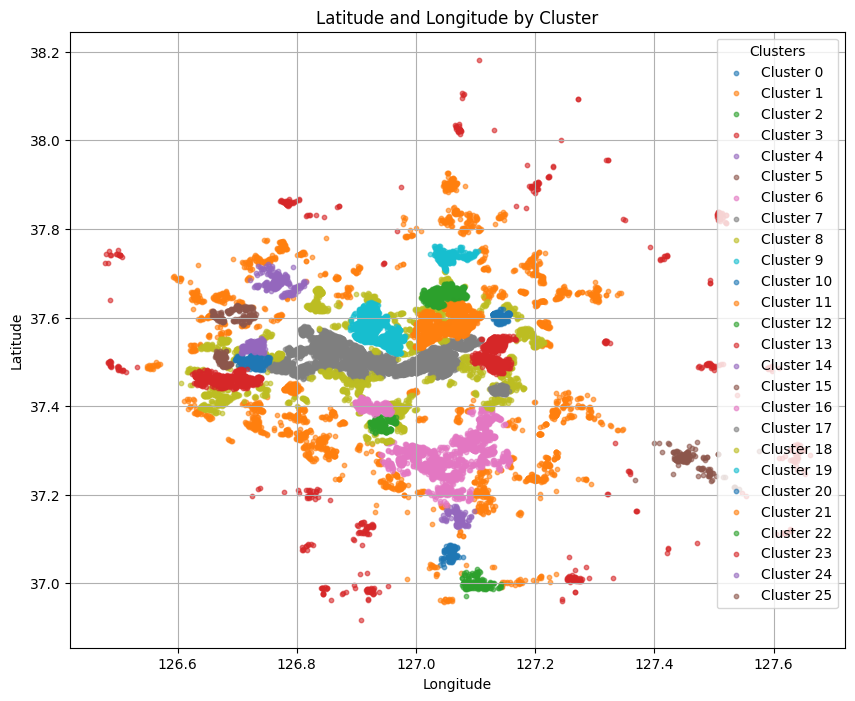

In [209]:
# 시각화 설정
plt.figure(figsize=(10, 8))
unique_clusters = apartment_final['cluster_final'].unique()

# 각 cluster_final에 대해 다른 색상으로 산포도 그리기
for cluster in unique_clusters:
    cluster_data = apartment_final[apartment_final['cluster_final'] == cluster]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                s=10, label=f'Cluster {cluster}', alpha=0.6)

# 그래프 설정
plt.title('Latitude and Longitude by Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='best', title='Clusters')
plt.grid(True)
plt.show()


## (5) test 데이터에만 있는 아파트들은 어떻게??

In [210]:
apartment_test = df[df['contract_year_month'] >= 202401][['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)


In [211]:
apartment_test_only = apartment_test[
    ~apartment_test[['latitude', 'longitude']].apply(tuple, axis=1).isin(
        apartment[['latitude', 'longitude']].apply(tuple, axis=1))
].reset_index(drop=True)

apartment_test_only


,latitude,longitude
0,37.585373,127.216700
1,37.579920,127.219972
2,37.297788,127.507601
3,36.994636,127.159744
4,37.606575,126.771683
...,...,...
180,37.540437,127.145738
181,37.499548,127.144838
182,37.463234,126.642899
183,37.459061,126.674991


In [212]:
# apartment_final에서 위도와 경도를 사용하여 최근접 이웃 모델 생성
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(apartment_final[['latitude', 'longitude']])

# apartment_test_only에서 위도, 경도를 기준으로 가장 가까운 이웃 찾기
distances, indices = nbrs.kneighbors(apartment_test_only[['latitude', 'longitude']])

# 가장 가까운 이웃의 cluster_final 라벨을 apartment_test_only에 할당
apartment_test_only['cluster_final'] = apartment_final.iloc[indices.flatten()]['cluster_final'].values


In [213]:
apartment_test_only

,latitude,longitude,cluster_final
0,37.585373,127.216700,1
1,37.579920,127.219972,1
2,37.297788,127.507601,5
3,36.994636,127.159744,1
4,37.606575,126.771683,1
...,...,...,...
180,37.540437,127.145738,13
181,37.499548,127.144838,13
182,37.463234,126.642899,23
183,37.459061,126.674991,23


## (6) 완성

In [216]:
apartment_concat = pd.concat([apartment_final, apartment_test_only], axis = 0).reset_index(drop=True)
apartment_concat

,latitude,longitude,cluster_final
0,37.054314,127.045216,0
1,36.964647,127.055847,1
2,36.972390,127.084514,2
3,36.965423,127.048779,1
4,36.957089,127.047449,1
...,...,...,...
18671,37.540437,127.145738,13
18672,37.499548,127.144838,13
18673,37.463234,126.642899,23
18674,37.459061,126.674991,23


# 2. 가격을 기준으로 K-Means